# Final Model :

*   Custom built model for object detection.
*   Faster RCNN for object localization.



In [ ]:
#Importing essential libraries
%tensorflow_version 1.x
import tensorflow as tf
import random
import numpy as np
from google.colab import files
import pandas as pd
from tqdm import tqdm
import os
import math
import shutil
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import utils as u

TensorFlow 1.x selected.


In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Fixing python random seed
random.seed(42)
#fixing numpy random seed
np.random.seed(21)
#fixing tensorflow random seed
tf.compat.v1.random.set_random_seed(42)

In [ ]:
#Setting up variables
IMG_WIDTH = 30
IMG_HEIGHT = 30
N_CHANNELS = 3
N_CLASSES = 43
test_path = "/content/drive/My Drive/CaseStudy2/Test"
object_detection_model_path = "/content/drive/My Drive/CaseStudy2/BestScoreTillNow.h5"
test_df_path = "/content/drive/My Drive/CaseStudy2/Test.csv"

In [ ]:
#Downloading dataset from kaggle
def download_dataset_from_kaggle() :
  '''
  This function downloads the German traffic sign
  dataset from kaggle and stores it in temporary
  session memory of google colab and unzips it.
  '''
  #Upload the kaggle api token
  print('Please upload the kaggle api token :')
  files.upload() #this will prompt you to update the json
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json  # set permission

  #Downloading and unzipping the dataset
  !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
  !unzip -q /content/gtsrb-german-traffic-sign.zip -d Data
download_dataset_from_kaggle()

Please upload the kaggle api token :


Saving kaggle.json to kaggle.json
kaggle.json
 97% 593M/612M [00:05<00:00, 101MB/s] 
100% 612M/612M [00:05<00:00, 121MB/s]


In [ ]:
!mkdir "/content/Desktop"
%cd "/content/Desktop"
!git clone https://github.com/tensorflow/models.git

/content/Desktop
Cloning into 'models'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 38757 (delta 26), reused 23 (delta 0), pack-reused 38708
Receiving objects: 100% (38757/38757), 546.76 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (25984/25984), done.


In [ ]:
!mkdir "/content/Desktop/models/research/object_detection/images"
!mkdir "/content/Desktop/models/research/object_detection/training"

In [ ]:
test_df = pd.read_csv("/content/Data/Test.csv")

test_df = test_df[['Path', 'Width', 'Height', 'ClassId', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']]

for itr in tqdm(range(test_df.shape[0])) :
  test_df.iloc[itr, 0] = "/content/Desktop/models/research/object_detection/images/" + test_df.iloc[itr, 0]
  test_df.iloc[itr, 3] += 1

test_df = test_df.rename(columns={'Path' : 'filename',
                         'Width' : 'width',
                         'Height' : 'height',
                         'ClassId' : 'class',
                         'Roi.X1' : 'xmin', 
                         'Roi.Y1' : 'ymin',
                         'Roi.X2' : 'xmax',
                         'Roi.Y2' : 'ymax'})

test_df.to_csv("/content/Desktop/models/research/object_detection/data/test_labels.csv")

100%|██████████| 12630/12630 [00:18<00:00, 687.52it/s]


In [ ]:
!mv "/content/Data/Test" "/content/Desktop/models/research/object_detection/images/"

In [ ]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,818 kB of archives.
After this operation, 7,685 kB of additional disk space will be used.
Get:1 htt

In [ ]:
%cd "/content/Desktop/models/research"
!protoc object_detection/protos/*.proto --python_out=.

/content/Desktop/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [ ]:
os.environ['PYTHONPATH'] += ':/content/Desktop/models/research/:/content/Desktop/models/research/slim'

In [ ]:
!python setup.py build
!python setup.py install

running build
running build_py
creating build
creating build/lib
creating build/lib/object_detection
copying object_detection/inputs.py -> build/lib/object_detection
copying object_detection/model_main_tf2.py -> build/lib/object_detection
copying object_detection/__init__.py -> build/lib/object_detection
copying object_detection/model_tpu_main.py -> build/lib/object_detection
copying object_detection/export_inference_graph.py -> build/lib/object_detection
copying object_detection/model_main.py -> build/lib/object_detection
copying object_detection/model_lib_v2.py -> build/lib/object_detection
copying object_detection/model_lib_tf2_test.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib_tf1_test.py -> build/lib/object_detection
copying object_detection/eval_util_test.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib.py -> build/lib/object_detection
copying object_detection/model_lib_tf1_test.py -> build/lib/object_de

In [ ]:
!pip install tf_slim
%cd /content/Desktop/models/research/object_detection/builders/
!python model_builder_test.py

     |████████████████████████████████| 358kB 2.7MB/s 
/content/Desktop/models/research/object_detection/builders


### Upload following files into their respective directories before moving forward :

*   generate_tfrecord.py in object_detection folder.
*   utils_frcnn.py in object_detection folder.
*   label_map.pbtxt in training folder.
*   config file in training folder.




In [ ]:
%cd "/content/Desktop/models/research/object_detection"
!python generate_tfrecord.py --label='GTSRB' --csv_input=data/test_labels.csv --img_path=images/Test  --output_path=training/test.record

/content/Desktop/models/research/object_detection
Successfully created the TFRecords: /content/Desktop/models/research/object_detection/training/test.record


In [ ]:
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz
!tar -xvf faster_rcnn_resnet101_coco_2018_01_28.tar.gz

--2020-07-14 17:56:27--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.97.128, 2404:6800:4008:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.97.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593445323 (566M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet101_coco_2018_01_28.tar.gz’

faster_rcnn_resnet1 100%[===================>] 565.95M   130MB/s    in 4.5s    

2020-07-14 17:56:32 (126 MB/s) - ‘faster_rcnn_resnet101_coco_2018_01_28.tar.gz’ saved [593445323/593445323]

faster_rcnn_resnet101_coco_2018_01_28/
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.index
faster_rcnn_resnet101_coco_2018_01_28/checkpoint
faster_rcnn_resnet101_coco_2018_01_28/pipeline.config
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.meta
faster_rcnn_res

In [ ]:
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
### Model preparation variable
#MODEL_NAME = 'trained_inference_graph'
PATH_TO_FROZEN_GRAPH = '/content/drive/My Drive/CaseStudy2/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training/label_map.pbtxt'
NUM_CLASSES = 1 #remember number of objects you are training? cool.

### Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

###Loading label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Load image into numpy function
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

###STATING THE PATH TO IMAGES TO BE TESTED
PATH_TO_TEST_IMAGES_DIR = 'test_images/'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.png'.format(i)) for i in range(1, 10) ]
TEST_IMAGE_PATHS = test_df.iloc[:, 0]
IMAGE_SIZE = (256, 256)

In [ ]:
#Loading classification model
object_detection_model = u.get_model(IMG_WIDTH, IMG_HEIGHT, N_CHANNELS, N_CLASSES)
object_detection_model.load_weights(object_detection_model_path)
object_detection_model.compile()

In [ ]:
import utils_frcnn as u_frcnn
from sklearn.metrics import f1_score, mean_squared_error
def final_fun_1(image_path) :
    actual_label = image_path[3]
    image_path = image_path[0]
    label = u.evaluate_test_images(image_path, object_detection_model, IMG_WIDTH=IMG_WIDTH, IMG_HEIGHT=IMG_HEIGHT, N_CHANNELS=N_CHANNELS)
    label = np.array(label).reshape(1)
    image = Image.open(image_path)
    image_np = u_frcnn.load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = u_frcnn.run_inference_for_single_image(image_np_expanded, detection_graph)
    vis_util.visualize_boxes_and_labels_on_image_array(
      image = image_np,
      boxes = output_dict['detection_boxes'],
      classes = label,
      scores = output_dict['detection_scores'],
      category_index = category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=1)
    display(Image.fromarray(image_np))
    print("Predicted Label : {0}".format(label[0]))
    print("Actual Label : {0}".format(actual_label-1))
    print("\n")
    #return label, output_dict['detection_boxes'][0]

## Making some predictions for some single test set images :

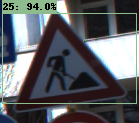

Predicted Label : 25
Actual Label : 25




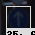

Predicted Label : 35
Actual Label : 35




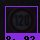

Predicted Label : 8
Actual Label : 8




Predicted Label : 12
Actual Label : 12




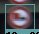

Predicted Label : 10
Actual Label : 10




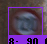

Predicted Label : 8
Actual Label : 8




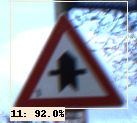

Predicted Label : 11
Actual Label : 11




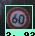

Predicted Label : 3
Actual Label : 3




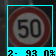

Predicted Label : 2
Actual Label : 2




Predicted Label : 3
Actual Label : 3




In [ ]:
for itr in random.sample(range(test_df.shape[0]), 10) :
  final_fun_1(test_df.iloc[itr])

In [ ]:
def final_fun_2() :
  """
  Returns score for the test set
  """
  #Getting predictions for the test set images
  labels_pred = []
  bbox_pred = []
  for itr in tqdm(range(test_df.shape[0])) :
    label, bbox = final_fun_1(test_df.iloc[itr])
    labels_pred.append(label)
    bbox_pred.append(bbox)
  test_f1_score = f1_score(test_df['ClassId'], labels_pred, average = 'weighted')
  test_mse = mean_squared_error(test_df.iloc[:, 2:6], bbox_pred)
  return test_f1_score, test_mse

In [ ]:
#printing test scores :
print("Test f1-score : {0:.2f}".format(test_f1_score))
print("Test Mean squared error : {0:.2f}".format(test_mse))

Test f1-score : 0.98
Test Mean squared error : 0.62
